In [1]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators2 import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm 
import matplotlib.pylab as plt

# Préalable

On tire $\mathbf{x}$ et $\theta$ au hasard dans $\mathbb{R}^{20}$ et on fixe les paramètres optimaux $A^*$ et $b^*$ (voir Rainforth 2018). Puis, on génére les paramètres $A$ et $b$ en ajoutant un bruit gaussien.

In [2]:
np.random.seed(589)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
z=simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
x=simulate_gaussian_vector(mu=z, sigma=np.identity(20)) #on sait simuler x|z

A_optimal=np.identity(20)*0.5
b_optimal=theta/2

A=A_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))
b=b_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))

# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationel espéré de chaque estimateur soit de 6.

In [3]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -37.19
Estimateur IAWE de la log-vraisemblance: -39.81
Estimateur SUMO de la log-vraisemblance: -41.17
Estimateur ML-SS de la log-vraisemblance: -38.37
Estimateur ML-RR de la log-vraisemblance: -39.54


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationel espéré de chaque estimateur soit environ de 12.

In [4]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -37.19
Estimateur IAWE de la log-vraisemblance: -39.48
Estimateur SUMO de la log-vraisemblance: -37.69
Estimateur ML-SS de la log-vraisemblance: -43.34
Estimateur ML-RR de la log-vraisemblance: -39.92


## Coût des estimateurs

On suppose que les estimateurs ML-SS, ML-RR et SUMO contiennent une période de chauffe $l$.
* IWAE: pour produire l'estimateur, on sample $k$ variables aléatoires. Le coût est déterministe: $\mathbb{E}[C_{IWAE}]=C_{IWAE}=k$
* ML-SS: pour produire l'estimateur, on sample $2^{K+l+1}$ variables aléatoires, où $K \sim \mathcal{G}(0,6) $. Donc $C_{ML-SS}=2^{K+l+1}$ est aléatoire.
$\mathbb{E}(C_{ML-SS})=6.2^l$
* ML-RR: pour produire l'estimateur, on sample $\sum_{k=0}^{K} 2^{k+l+1}$ variables. Donc $C_{ML-RR}=\sum_{k=0}^K 2^{k+l+1}$. $\mathbb{E}(C_{ML-RR})=6.2^l$
* SUMO: pour produire l'estimateur, on sample $\sum_{k=0}^K(k+l+2)=\frac{K(K+1)}{2}+(l+2)K$ variables. Donc, $C_{SUMO}=\frac{K(K+1)}{2}+(l+2)K$. $\mathbb{E}(C_{SUMO})=\frac{55}{9}+\frac{5}{3}l$

## Procédure de Monte Carlo

On met en place une procédure de Monte Carlo pour estimer le biais et la variance des estimateurs, en fonction du coût computationel, pour chaque méthode/

L'algorithme est le suivant:

Pour $k$ allant de 1 à $\mathbf{E}(C)$, faire:

Pour m allant de 1 à M, faire:

Calculer chaque estimateur au point $\mathbb{x}$: $estimateur_{m,l}$

Calculer:

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} - l(x;\theta)

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M}( estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l})^{2}

\end{equation}

Fin pour

Fin pour

Retourner $biais_{M,l}, ..., Var_{M,l}$

Les auteurs de l'article prennent $M=1000$.

In [5]:
def procedure_MC_logvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=0
    while l<=L:
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            log_vraisemblance_estim_IWAE=importance_sampling_logvraisemblance(k=6*2**l, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO=estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            log_vraisemblance_estim_SS=estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_RR=estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)


            estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, log_vraisemblance_estim_IWAE)
            estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, log_vraisemblance_estim_SUMO)
            estimations_SS_M_l=np.append(estimations_SS_M_l, log_vraisemblance_estim_SS)
            estimations_RR_M_l=np.append(estimations_RR_M_l, log_vraisemblance_estim_RR)
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l)-log_vraisemblance(x=x, theta=theta)

        var_IWAE_M_l=np.var(estimations_IWAE_M_l)
        var_SUMO_M_l=np.var(estimations_SUMO_M_l)
        var_SS_M_l=np.var(estimations_SS_M_l)
        var_RR_M_l=np.var(estimations_RR_M_l)

        biais_IWAE_M[l]=biais_IWAE_M_l
        biais_SUMO_M[l]=biais_SUMO_M_l
        biais_SS_M[l]=biais_SS_M_l
        biais_RR_M[l]=biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [6]:
np.random.seed(589)

biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M = procedure_MC_logvraisemblance(M=1000, 
                                                                                                                               L=6, 
                                                                                                                               x=x, 
                                                                                                                               theta=theta, 
                                                                                                                               A=A, 
                                                                                                                               b=b)


In [ ]:
sorted_biais_IWAE_M = sorted(biais_IWAE_M.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_M.items())
sorted_biais_SS_M = sorted(biais_SS_M.items())
sorted_biais_RR_M = sorted(biais_RR_M.items())

sorted_var_IWAE_M = sorted(var_IWAE_M.items())
sorted_var_SUMO_M = sorted(var_SUMO_M.items())
sorted_var_SS_M = sorted(var_SS_M.items())
sorted_var_RR_M = sorted(var_RR_M.items())

l, biais_IAWE = zip(*sorted_biais_IWAE_M)
l, biais_SUMO = zip(*sorted_biais_SUMO_M)
l, biais_SS = zip(*sorted_biais_SS_M)
l, biais_RR = zip(*sorted_biais_RR_M)

l, var_SUMO = zip(*sorted_var_SUMO_M) 
l, var_SS = zip(*sorted_var_SS_M) 
l, var_RR = zip(*sorted_var_RR_M)
l, var_IAWE = zip(*sorted_var_IWAE_M) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(l, np.square(biais_IAWE), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(l, np.square(biais_SUMO), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(l, np.square(biais_SS), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(l, np.square(biais_RR), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(l, var_IAWE, 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(l, var_SUMO, 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(l, var_SS, 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(l, var_RR, 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()
plt.yscale("log")
plt.show()

NameError: name 'biais_IWAE_M' is not defined

# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la  log-vraisemblance au point $\mathbf{x}$.On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationel espéré de chaque estimateur soit de 6.

In [15]:
np.random.seed(589)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))

Vraie valeur du gradient de la log-vraisemblance au point x: [ 0.3   3.5  -2.41 -1.4   5.51  1.34 -2.3   2.31  6.8   1.79 -1.86  1.57
 -2.45  3.51  4.47 -0.54 -0.3  -2.54 -0.26  5.15]
Estimateur IAWE du gradient de la log-vraisemblance: [ 0.44  0.08  0.95 -0.    2.02  0.48 -0.3  -0.35  1.99  0.17  0.71  1.11
  0.22  1.06 -0.2  -0.26  0.19  0.85  0.6   0.85]
Estimateur SUMO du gradient de la log-vraisemblance: [ 0.07  0.94 -0.34 -0.91  1.2   0.68  0.29  0.32  2.47  0.39 -0.33  0.88
  0.02  1.47  1.47 -0.12  0.19  0.3   0.47  0.67]
Estimateur ML-SS du gradient de la log-vraisemblance: [42.06  1.29  4.14 15.58 16.08  9.56  3.23 -0.31 15.75  2.67 11.94 -1.1
  3.32  5.06  3.89  8.01  7.32  5.07  7.46 10.91]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 3.26  0.5   0.25 -0.14  2.65  2.49  0.98  1.92  2.52  0.52  1.66 -0.52
  2.63  2.46  2.28  1.09  0.46 -1.16  1.67  4.13]


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationel espéré de chaque estimateur soit environ de 12.

In [ ]:
np.random.seed(589)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))

## Procédure de Monte Carlo

Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_M=\frac{1}{M} \sum_{m=1}^{M} estimateur_m - \nabla_{\theta}l(x;\theta)

\end{equation}

\begin{equation}

    biais^2_M=\lVert biais_M \rVert^2

\end{equation}

\begin{equation}

    Var_M=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_m - \frac{1}{M} \sum_{m=1}^{M} estimateur_m \rVert^{2}

\end{equation}

In [14]:
def procedure_MC_gradientlogvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=0
    while l<=L:
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            gradient_log_vraisemblance_estim_IWAE=importance_sampling_gradientlogvraisemblance(k=6*2**l, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO=estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            gradient_log_vraisemblance_estim_SS=estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_RR=estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            if m==1:
                estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_M_l=np.append(estimations_SS_M_l, gradient_log_vraisemblance_estim_SS)
                estimations_RR_M_l=np.append(estimations_RR_M_l, gradient_log_vraisemblance_estim_RR)
            
            else:
                estimations_IWAE_M_l= np.vstack((estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_M_l=np.vstack((estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_M_l=np.vstack((estimations_SS_M_l, gradient_log_vraisemblance_estim_SS))
                estimations_RR_M_l=np.vstack((estimations_RR_M_l, gradient_log_vraisemblance_estim_RR))
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)

        squared_biais_IWAE_M_l=norm(biais_IWAE_M_l)**2
        squared_biais_SUMO_M_l=norm(biais_SUMO_M_l)**2
        squared_biais_SS_M_l=norm(biais_SS_M_l)**2
        squared_biais_RR_M_l=norm(biais_RR_M_l)**2

        var_IWAE_M_l=np.mean(norm(estimations_IWAE_M_l-np.mean(estimations_IWAE_M_l, axis=0), axis=1)**2)
        var_SUMO_M_l=np.mean(norm(estimations_SUMO_M_l-np.mean(estimations_SUMO_M_l, axis=0), axis=1)**2)
        var_SS_M_l=np.mean(norm(estimations_SS_M_l-np.mean(estimations_SS_M_l, axis=0), axis=1)**2)
        var_RR_M_l=np.mean(norm(estimations_RR_M_l-np.mean(estimations_RR_M_l, axis=0), axis=1)**2)

        biais_IWAE_M[l]=squared_biais_IWAE_M_l
        biais_SUMO_M[l]=squared_biais_SUMO_M_l
        biais_SS_M[l]=squared_biais_SS_M_l
        biais_RR_M[l]=squared_biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [18]:
np.random.seed(589)

biais_IWAE_M_gradient, biais_SUMO_M_gradient, biais_SS_M_gradient, biais_RR_M_gradient, var_IWAE_M_gradient, var_SUMO_M_gradient, var_SS_M_gradient, var_RR_M_gradient = procedure_MC_gradientlogvraisemblance(M=500, 
                                                                                                                                                                                                        L=6, 
                                                                                                                                                                                                        x=x, 
                                                                                                                                                                                                        theta=theta, 
                                                                                                                                                                                                        A=A, 
                                                                                                                                                                                                        b=b)

C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_IAWE_gradient), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_SUMO_gradient), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_SS_gradient), 'b', label="Biais

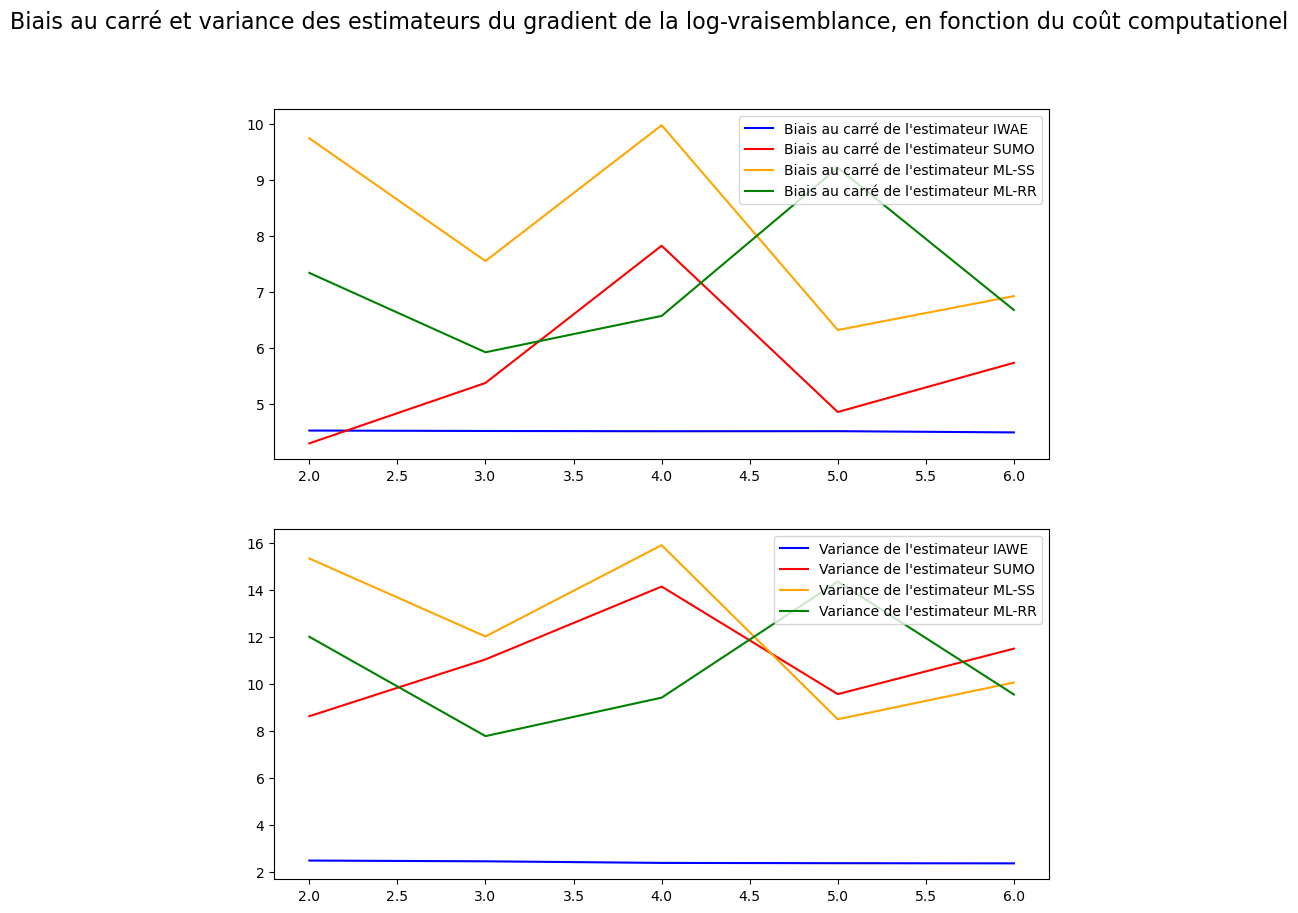

In [29]:
sorted_biais_IWAE_M_gradient = sorted(biais_IWAE_M_gradient.items())
sorted_biais_SUMO_M_gradient = sorted(biais_SUMO_M_gradient.items())
sorted_biais_SS_M_gradient = sorted(biais_SS_M_gradient.items())
sorted_biais_RR_M_gradient = sorted(biais_RR_M_gradient.items())

sorted_var_IWAE_M_gradient = sorted(var_IWAE_M_gradient.items())
sorted_var_SUMO_M_gradient = sorted(var_SUMO_M_gradient.items())
sorted_var_SS_M_gradient = sorted(var_SS_M_gradient.items())
sorted_var_RR_M_gradient = sorted(var_RR_M_gradient.items())

l, biais_IAWE_gradient = zip(*sorted_biais_IWAE_M_gradient)
l, biais_SUMO_gradient = zip(*sorted_biais_SUMO_M_gradient)
l, biais_SS_gradient = zip(*sorted_biais_SS_M_gradient)
l, biais_RR_gradient = zip(*sorted_biais_RR_M_gradient)

l, var_IAWE_gradient = zip(*sorted_var_IWAE_M_gradient) 
l, var_SUMO_gradient = zip(*sorted_var_SUMO_M_gradient) 
l, var_SS_gradient = zip(*sorted_var_SS_M_gradient) 
l, var_RR_gradient = zip(*sorted_var_RR_M_gradient) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(l, (biais_IAWE_gradient), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(l, (biais_SUMO_gradient), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(l, (biais_SS_gradient), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(l, (biais_RR_gradient), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs du gradient de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(l, (var_IAWE_gradient), 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(l, (var_SUMO_gradient), 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(l, (var_SS_gradient), 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(l, (var_RR_gradient), 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.yscale("log")
plt.show()